In [1]:
### CONFIG ###
from trafficgraphnn.sumo_network import SumoNetwork

sn = SumoNetwork(
    'data/networks/simonnet/simonnet.net.xml', routefile='data/networks/simonnet/simonnet_rand_routes.routes.xml',
    lanewise=True, addlfiles=['data/networks/simonnet/simonnet_e1.add.xml', 'data/networks/simonnet/simonnet_e2.add.xml', 'data/networks/simonnet/tls_output.add.xml']
)
#sn.run()

2018-08-08 14:27:26,958 matplotlib.font_manager:1465 DEBUG    Using fontManager instance from /home/simon/.cache/matplotlib/fontList.json
2018-08-08 14:27:27,143 matplotlib.backends:90  DEBUG    backend module://ipykernel.pylab.backend_inline version unknown
2018-08-08 14:27:27,455 matplotlib.backends:90  DEBUG    backend module://ipykernel.pylab.backend_inline version unknown


In [13]:
from trafficgraphnn.preprocess_data import PreprocessData
import numpy as np
preprocess = PreprocessData(sn)

A, X_train_tens, Y_train_tens, X_test_tens, Y_test_tens, X_val_tens, Y_val_tens = preprocess.preprocess_for_gat(average_interval = 1, sample_size = 10)
print('X_train shape:', X_train_tens.shape)
print('Y_train shape:', Y_train_tens.shape)
print('X_test shape:', X_test_tens.shape)
print('X_val shape:', X_val_tens.shape)
A = np.eye(120,120) + A

number of samples: 50
number of samples: 50
number of samples: 50
X_train shape: (50, 10, 120, 8)
Y_train shape: (50, 10, 120, 1)
X_test shape: (50, 10, 120, 8)
X_val shape: (50, 10, 120, 8)


In [3]:

#A_tens = np.empty((X_train_tens.shape[0], X_train_tens.shape[1], X_train_tens.shape[0]))
#for timestep in range(X_train_tens.shape[1]):
#    A_tens[:, timestep, :] = A   
#print(A_tens.shape)


#print('Adjacency matrix:', A)

In [16]:
from __future__ import division
import numpy as np

import tensorflow as tf
from keras.callbacks import EarlyStopping, TensorBoard
from keras.layers import Input, Dropout, Dense, TimeDistributed
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD, Adagrad
from keras.regularizers import l2

from keras_gat import GraphAttention
from keras_gat.utils import load_data


In [22]:
# Parameters
sample_size = X_train_tens.shape[1] #Number of timesteps in a sample
N = X_train_tens.shape[2]          # Number of nodes in the graph
F = X_train_tens.shape[3]          # Original feature dimensionality
F_ = Y_train_tens.shape[3]         # Output dimension of first GraphAttention layer
n_attn_heads = 5              # Number of attention heads in first GAT layer
dropout_rate = 0            # Dropout rate applied to the input of GAT layers
l2_reg = 5e-100               # Regularization rate for l2
learning_rate = 5e-3       # Learning rate for SGD
epochs = 2000                # Number of epochs to run for
es_patience = 100             # Patience fot early stopping

print('N:', N)
print('F:', F)
print('F_:', F_)

# Model definition (as per Section 3.3 of the paper)
#X_in = Input(shape=(F,))
#A_in = Input(shape=(N,))

X_train_tf_tens = tf.convert_to_tensor(X_train_tens, dtype=np.float32)
A_tf = tf.convert_to_tensor(A, dtype=np.float32)
X_in = Input(shape=(sample_size, N, F))
#A_in = Input(shape=(10,120))

dropout1 = TimeDistributed(Dropout(dropout_rate), input_shape = (sample_size, N, F))(X_in)

graph_attention_1 = TimeDistributed(GraphAttention(100,
                                   A_tf,
                                   attn_heads=n_attn_heads,
                                   attn_heads_reduction='average',
                                   attn_dropout=0,
                                   activation='linear',
                                   kernel_regularizer=l2(l2_reg)),
                                   input_shape = (sample_size, N, F))(dropout1)

dropout2 = TimeDistributed(Dropout(dropout_rate))(graph_attention_1)

graph_attention_2 = TimeDistributed(GraphAttention(F_,
                                   A_tf,
                                   attn_heads=n_attn_heads,
                                   attn_heads_reduction='average',
                                   attn_dropout=0,
                                   activation='linear',
                                   kernel_regularizer=l2(l2_reg)))(dropout2)

#dense = TimeDistributed(Dense(8), input_shape = (sample_size, N, F))(graph_attention_2)

#dropout3 = Dropout(dropout_rate)(graph_attention_2)
#graph_attention_3 = GraphAttention(F_,
#                                   attn_heads=n_attn_heads,
#                                   attn_heads_reduction='average',
#                                   attn_dropout=0,
#                                   activation='linear',
#                                   kernel_regularizer=l2(l2_reg))([dropout3, A_in])

# Build model
model = Model(inputs=X_in, outputs=graph_attention_2)
optimizer = Adagrad(lr=learning_rate)
model.compile(optimizer=optimizer,
              loss='mean_squared_error',
              weighted_metrics=['accuracy'])
model.summary()
print("Inputs: {}".format(model.input_shape))
print("Outputs: {}".format(model.output_shape))
print("Actual input: {}".format(X_train_tens.shape))
print("Actual output: {}".format(Y_train_tens.shape))

# Train model


print(X_train_tf_tens.shape)
validation_data = (X_train_tens, Y_train_tens)
history = model.fit(X_train_tens,
          Y_train_tens,
          epochs=epochs,
          validation_data = validation_data,
          shuffle=False,  # Shuffling data means shuffling the whole graph
         )

import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
#plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
#plt.title('model accuracy')
#plt.ylabel('accuracy')
#plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
#plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Evaluate model
eval_results = model.evaluate(X_train_tf_tens,
                              X_train_tf_tens,
                              batch_size=N,
verbose=0)

print('Done.\n'
      'Test loss: {}\n'
'Test accuracy: {}'.format(*eval_results))




N: 120
F: 8
F_: 1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        (None, 10, 120, 8)        0         
_________________________________________________________________
time_distributed_51 (TimeDis (None, 10, 120, 8)        0         
_________________________________________________________________
time_distributed_52 (TimeDis (None, 10, 100)           5000      
_________________________________________________________________
time_distributed_53 (TimeDis (None, 10, 100)           0         
_________________________________________________________________
time_distributed_54 (TimeDis (None, 10, 1)             510       
Total params: 5,510
Trainable params: 5,510
Non-trainable params: 0
_________________________________________________________________
Inputs: (None, 10, 120, 8)
Outputs: (None, 10, 1)
Actual input: (50, 10, 120, 8)
Actual output: (50, 10, 120, 1)
(50, 10, 

ValueError: Error when checking target: expected time_distributed_54 to have 3 dimensions, but got array with shape (50, 10, 120, 1)

In [32]:
td1 =model.layers[2]

In [41]:
td1.built

True

In [40]:
td1.layer.

<tf.Tensor 'Const_27:0' shape=(120, 120) dtype=float32>

In [6]:
import pandas as pd
prediction = model.predict([X_train, A], batch_size = N)

#processed_data = pd.read_hdf('data/networks/simonnet/e1_detector_data_15_seconds.h5')
#processed_data
error = prediction - X_train

NameError: name 'X_train' is not defined

Visualization X_train:


NameError: name 'X_train' is not defined

2018-08-02 10:50:24,022 matplotlib.font_manager:1343 DEBUG    findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/home/simon/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


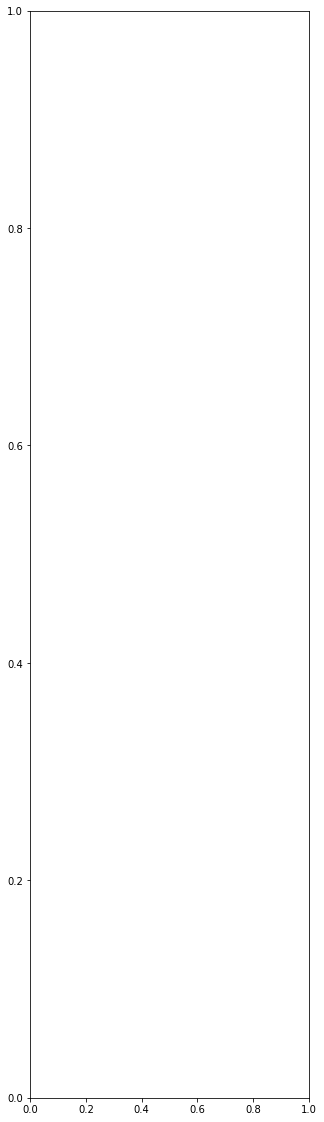

In [7]:
import matplotlib.pyplot as plt

print('Visualization X_train:')
fig = plt.figure(figsize=(5, 20))
ax = fig.add_subplot(111)
cax = ax.matshow(X_train, vmin=-100, vmax=100)
fig.colorbar(cax)
plt.show()

print('Visualization Prediction:')
fig = plt.figure(figsize=(5, 20))
ax = fig.add_subplot(111)
cax = ax.matshow(prediction, vmin=-100, vmax=100)
fig.colorbar(cax)
plt.show()

print('Visualization Error:')
fig = plt.figure(figsize=(5, 20))
ax = fig.add_subplot(111)
cax = ax.matshow(error, vmin=-100, vmax=100)
fig.colorbar(cax)
plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 10, 8)             0         
_________________________________________________________________
time_distributed_53 (TimeDis (None, 10, 50)            450       
_________________________________________________________________
time_distributed_54 (TimeDis (None, 10, 50)            0         
_________________________________________________________________
time_distributed_55 (TimeDis (None, 10, 50)            2550      
_________________________________________________________________
time_distributed_56 (TimeDis (None, 10, 50)            0         
_________________________________________________________________
time_distributed_57 (TimeDis (None, 10, 8)             408       
Total params: 3,408
Trainable params: 3,408
Non-trainable params: 0
_________________________________________________________________
Train on

Epoch 47/2000
1/1 [==============================] - 0s 16ms/step - loss: 147.6925 - weighted_acc: 0.9058 - val_loss: 144.9639 - val_weighted_acc: 0.9275
Epoch 48/2000
1/1 [==============================] - 0s 18ms/step - loss: 144.9639 - weighted_acc: 0.9275 - val_loss: 142.2938 - val_weighted_acc: 0.9333
Epoch 49/2000
1/1 [==============================] - 0s 20ms/step - loss: 142.2938 - weighted_acc: 0.9333 - val_loss: 139.6801 - val_weighted_acc: 0.9375
Epoch 50/2000
1/1 [==============================] - 0s 19ms/step - loss: 139.6801 - weighted_acc: 0.9375 - val_loss: 137.1222 - val_weighted_acc: 0.9375
Epoch 51/2000
1/1 [==============================] - 0s 17ms/step - loss: 137.1222 - weighted_acc: 0.9375 - val_loss: 134.6176 - val_weighted_acc: 0.9375
Epoch 52/2000
1/1 [==============================] - 0s 18ms/step - loss: 134.6176 - weighted_acc: 0.9375 - val_loss: 132.1660 - val_weighted_acc: 0.9383
Epoch 53/2000
1/1 [==============================] - 0s 22ms/step - loss: 13

Epoch 101/2000
1/1 [==============================] - 0s 13ms/step - loss: 57.5669 - weighted_acc: 0.9483 - val_loss: 56.6418 - val_weighted_acc: 0.9483
Epoch 102/2000
1/1 [==============================] - 0s 11ms/step - loss: 56.6418 - weighted_acc: 0.9483 - val_loss: 55.7346 - val_weighted_acc: 0.9483
Epoch 103/2000
1/1 [==============================] - 0s 15ms/step - loss: 55.7346 - weighted_acc: 0.9483 - val_loss: 54.8448 - val_weighted_acc: 0.9475
Epoch 104/2000
1/1 [==============================] - 0s 13ms/step - loss: 54.8448 - weighted_acc: 0.9475 - val_loss: 53.9721 - val_weighted_acc: 0.9475
Epoch 105/2000
1/1 [==============================] - 0s 11ms/step - loss: 53.9721 - weighted_acc: 0.9475 - val_loss: 53.1163 - val_weighted_acc: 0.9467
Epoch 106/2000
1/1 [==============================] - 0s 14ms/step - loss: 53.1163 - weighted_acc: 0.9467 - val_loss: 52.2770 - val_weighted_acc: 0.9467
Epoch 107/2000
1/1 [==============================] - 0s 16ms/step - loss: 52.2770

Epoch 155/2000
1/1 [==============================] - 0s 16ms/step - loss: 26.3415 - weighted_acc: 0.9450 - val_loss: 26.0173 - val_weighted_acc: 0.9450
Epoch 156/2000
1/1 [==============================] - 0s 16ms/step - loss: 26.0173 - weighted_acc: 0.9450 - val_loss: 25.6993 - val_weighted_acc: 0.9450
Epoch 157/2000
1/1 [==============================] - 0s 13ms/step - loss: 25.6993 - weighted_acc: 0.9450 - val_loss: 25.3874 - val_weighted_acc: 0.9450
Epoch 158/2000
1/1 [==============================] - 0s 13ms/step - loss: 25.3874 - weighted_acc: 0.9450 - val_loss: 25.0814 - val_weighted_acc: 0.9450
Epoch 159/2000
1/1 [==============================] - 0s 12ms/step - loss: 25.0814 - weighted_acc: 0.9450 - val_loss: 24.7812 - val_weighted_acc: 0.9450
Epoch 160/2000
1/1 [==============================] - 0s 13ms/step - loss: 24.7812 - weighted_acc: 0.9450 - val_loss: 24.4866 - val_weighted_acc: 0.9450
Epoch 161/2000
1/1 [==============================] - 0s 18ms/step - loss: 24.4866

Epoch 209/2000
1/1 [==============================] - 0s 19ms/step - loss: 15.2523 - weighted_acc: 0.9492 - val_loss: 15.1327 - val_weighted_acc: 0.9492
Epoch 210/2000
1/1 [==============================] - 0s 17ms/step - loss: 15.1327 - weighted_acc: 0.9492 - val_loss: 15.0152 - val_weighted_acc: 0.9492
Epoch 211/2000
1/1 [==============================] - 0s 23ms/step - loss: 15.0152 - weighted_acc: 0.9492 - val_loss: 14.8996 - val_weighted_acc: 0.9492
Epoch 212/2000
1/1 [==============================] - 0s 23ms/step - loss: 14.8996 - weighted_acc: 0.9492 - val_loss: 14.7861 - val_weighted_acc: 0.9492
Epoch 213/2000
1/1 [==============================] - 0s 15ms/step - loss: 14.7861 - weighted_acc: 0.9492 - val_loss: 14.6744 - val_weighted_acc: 0.9492
Epoch 214/2000
1/1 [==============================] - 0s 15ms/step - loss: 14.6744 - weighted_acc: 0.9492 - val_loss: 14.5646 - val_weighted_acc: 0.9492
Epoch 215/2000
1/1 [==============================] - 0s 24ms/step - loss: 14.5646

Epoch 263/2000
1/1 [==============================] - 0s 20ms/step - loss: 10.9143 - weighted_acc: 0.9458 - val_loss: 10.8623 - val_weighted_acc: 0.9458
Epoch 264/2000
1/1 [==============================] - 0s 26ms/step - loss: 10.8623 - weighted_acc: 0.9458 - val_loss: 10.8111 - val_weighted_acc: 0.9458
Epoch 265/2000
1/1 [==============================] - 0s 26ms/step - loss: 10.8111 - weighted_acc: 0.9458 - val_loss: 10.7605 - val_weighted_acc: 0.9458
Epoch 266/2000
1/1 [==============================] - 0s 21ms/step - loss: 10.7605 - weighted_acc: 0.9458 - val_loss: 10.7105 - val_weighted_acc: 0.9458
Epoch 267/2000
1/1 [==============================] - 0s 29ms/step - loss: 10.7105 - weighted_acc: 0.9458 - val_loss: 10.6613 - val_weighted_acc: 0.9458
Epoch 268/2000
1/1 [==============================] - 0s 14ms/step - loss: 10.6613 - weighted_acc: 0.9458 - val_loss: 10.6126 - val_weighted_acc: 0.9450
Epoch 269/2000
1/1 [==============================] - 0s 12ms/step - loss: 10.6126

Epoch 317/2000
1/1 [==============================] - 0s 19ms/step - loss: 8.8338 - weighted_acc: 0.9433 - val_loss: 8.8053 - val_weighted_acc: 0.9433
Epoch 318/2000
1/1 [==============================] - 0s 14ms/step - loss: 8.8053 - weighted_acc: 0.9433 - val_loss: 8.7771 - val_weighted_acc: 0.9433
Epoch 319/2000
1/1 [==============================] - 0s 17ms/step - loss: 8.7771 - weighted_acc: 0.9433 - val_loss: 8.7491 - val_weighted_acc: 0.9433
Epoch 320/2000
1/1 [==============================] - 0s 15ms/step - loss: 8.7491 - weighted_acc: 0.9433 - val_loss: 8.7213 - val_weighted_acc: 0.9433
Epoch 321/2000
1/1 [==============================] - 0s 19ms/step - loss: 8.7213 - weighted_acc: 0.9433 - val_loss: 8.6938 - val_weighted_acc: 0.9433
Epoch 322/2000
1/1 [==============================] - 0s 17ms/step - loss: 8.6938 - weighted_acc: 0.9433 - val_loss: 8.6666 - val_weighted_acc: 0.9433
Epoch 323/2000
1/1 [==============================] - 0s 16ms/step - loss: 8.6666 - weighted_a

Epoch 372/2000
1/1 [==============================] - 0s 13ms/step - loss: 7.5586 - weighted_acc: 0.9392 - val_loss: 7.5396 - val_weighted_acc: 0.9392
Epoch 373/2000
1/1 [==============================] - 0s 16ms/step - loss: 7.5396 - weighted_acc: 0.9392 - val_loss: 7.5208 - val_weighted_acc: 0.9392
Epoch 374/2000
1/1 [==============================] - 0s 16ms/step - loss: 7.5208 - weighted_acc: 0.9392 - val_loss: 7.5020 - val_weighted_acc: 0.9392
Epoch 375/2000
1/1 [==============================] - 0s 15ms/step - loss: 7.5020 - weighted_acc: 0.9392 - val_loss: 7.4834 - val_weighted_acc: 0.9392
Epoch 376/2000
1/1 [==============================] - 0s 15ms/step - loss: 7.4834 - weighted_acc: 0.9392 - val_loss: 7.4649 - val_weighted_acc: 0.9392
Epoch 377/2000
1/1 [==============================] - 0s 14ms/step - loss: 7.4649 - weighted_acc: 0.9392 - val_loss: 7.4464 - val_weighted_acc: 0.9392
Epoch 378/2000
1/1 [==============================] - 0s 18ms/step - loss: 7.4464 - weighted_a

Epoch 427/2000
1/1 [==============================] - 0s 22ms/step - loss: 6.6540 - weighted_acc: 0.9350 - val_loss: 6.6397 - val_weighted_acc: 0.9350
Epoch 428/2000
1/1 [==============================] - 0s 24ms/step - loss: 6.6397 - weighted_acc: 0.9350 - val_loss: 6.6255 - val_weighted_acc: 0.9350
Epoch 429/2000
1/1 [==============================] - 0s 20ms/step - loss: 6.6255 - weighted_acc: 0.9350 - val_loss: 6.6113 - val_weighted_acc: 0.9350
Epoch 430/2000
1/1 [==============================] - 0s 14ms/step - loss: 6.6113 - weighted_acc: 0.9350 - val_loss: 6.5972 - val_weighted_acc: 0.9350
Epoch 431/2000
1/1 [==============================] - 0s 18ms/step - loss: 6.5972 - weighted_acc: 0.9350 - val_loss: 6.5832 - val_weighted_acc: 0.9358
Epoch 432/2000
1/1 [==============================] - 0s 16ms/step - loss: 6.5832 - weighted_acc: 0.9358 - val_loss: 6.5692 - val_weighted_acc: 0.9358
Epoch 433/2000
1/1 [==============================] - 0s 20ms/step - loss: 6.5692 - weighted_a

Epoch 482/2000
1/1 [==============================] - 0s 17ms/step - loss: 5.9501 - weighted_acc: 0.9367 - val_loss: 5.9386 - val_weighted_acc: 0.9367
Epoch 483/2000
1/1 [==============================] - 0s 15ms/step - loss: 5.9386 - weighted_acc: 0.9367 - val_loss: 5.9272 - val_weighted_acc: 0.9367
Epoch 484/2000
1/1 [==============================] - 0s 10ms/step - loss: 5.9272 - weighted_acc: 0.9367 - val_loss: 5.9158 - val_weighted_acc: 0.9367
Epoch 485/2000
1/1 [==============================] - 0s 17ms/step - loss: 5.9158 - weighted_acc: 0.9367 - val_loss: 5.9045 - val_weighted_acc: 0.9367
Epoch 486/2000
1/1 [==============================] - 0s 12ms/step - loss: 5.9045 - weighted_acc: 0.9367 - val_loss: 5.8932 - val_weighted_acc: 0.9367
Epoch 487/2000
1/1 [==============================] - 0s 12ms/step - loss: 5.8932 - weighted_acc: 0.9367 - val_loss: 5.8820 - val_weighted_acc: 0.9367
Epoch 488/2000
1/1 [==============================] - 0s 20ms/step - loss: 5.8820 - weighted_a

Epoch 537/2000
1/1 [==============================] - 0s 18ms/step - loss: 5.3763 - weighted_acc: 0.9367 - val_loss: 5.3668 - val_weighted_acc: 0.9358
Epoch 538/2000
1/1 [==============================] - 0s 16ms/step - loss: 5.3668 - weighted_acc: 0.9358 - val_loss: 5.3574 - val_weighted_acc: 0.9358
Epoch 539/2000
1/1 [==============================] - 0s 18ms/step - loss: 5.3574 - weighted_acc: 0.9358 - val_loss: 5.3480 - val_weighted_acc: 0.9358
Epoch 540/2000
1/1 [==============================] - 0s 19ms/step - loss: 5.3480 - weighted_acc: 0.9358 - val_loss: 5.3386 - val_weighted_acc: 0.9358
Epoch 541/2000
1/1 [==============================] - 0s 13ms/step - loss: 5.3386 - weighted_acc: 0.9358 - val_loss: 5.3292 - val_weighted_acc: 0.9358
Epoch 542/2000
1/1 [==============================] - 0s 21ms/step - loss: 5.3292 - weighted_acc: 0.9358 - val_loss: 5.3199 - val_weighted_acc: 0.9358
Epoch 543/2000
1/1 [==============================] - 0s 19ms/step - loss: 5.3199 - weighted_a

Epoch 592/2000
1/1 [==============================] - 0s 18ms/step - loss: 4.8963 - weighted_acc: 0.9358 - val_loss: 4.8883 - val_weighted_acc: 0.9358
Epoch 593/2000
1/1 [==============================] - 0s 20ms/step - loss: 4.8883 - weighted_acc: 0.9358 - val_loss: 4.8803 - val_weighted_acc: 0.9358
Epoch 594/2000
1/1 [==============================] - 0s 16ms/step - loss: 4.8803 - weighted_acc: 0.9358 - val_loss: 4.8724 - val_weighted_acc: 0.9358
Epoch 595/2000
1/1 [==============================] - 0s 16ms/step - loss: 4.8724 - weighted_acc: 0.9358 - val_loss: 4.8644 - val_weighted_acc: 0.9358
Epoch 596/2000
1/1 [==============================] - 0s 16ms/step - loss: 4.8644 - weighted_acc: 0.9358 - val_loss: 4.8565 - val_weighted_acc: 0.9358
Epoch 597/2000
1/1 [==============================] - 0s 15ms/step - loss: 4.8565 - weighted_acc: 0.9358 - val_loss: 4.8486 - val_weighted_acc: 0.9358
Epoch 598/2000
1/1 [==============================] - 0s 16ms/step - loss: 4.8486 - weighted_a

Epoch 647/2000
1/1 [==============================] - 0s 16ms/step - loss: 4.4878 - weighted_acc: 0.9367 - val_loss: 4.4809 - val_weighted_acc: 0.9367
Epoch 648/2000
1/1 [==============================] - 0s 17ms/step - loss: 4.4809 - weighted_acc: 0.9367 - val_loss: 4.4741 - val_weighted_acc: 0.9367
Epoch 649/2000
1/1 [==============================] - 0s 17ms/step - loss: 4.4741 - weighted_acc: 0.9367 - val_loss: 4.4672 - val_weighted_acc: 0.9367
Epoch 650/2000
1/1 [==============================] - 0s 15ms/step - loss: 4.4672 - weighted_acc: 0.9367 - val_loss: 4.4604 - val_weighted_acc: 0.9367
Epoch 651/2000
1/1 [==============================] - 0s 16ms/step - loss: 4.4604 - weighted_acc: 0.9367 - val_loss: 4.4536 - val_weighted_acc: 0.9367
Epoch 652/2000
1/1 [==============================] - 0s 17ms/step - loss: 4.4536 - weighted_acc: 0.9367 - val_loss: 4.4468 - val_weighted_acc: 0.9367
Epoch 653/2000
1/1 [==============================] - 0s 22ms/step - loss: 4.4468 - weighted_a

Epoch 702/2000
1/1 [==============================] - 0s 15ms/step - loss: 4.1353 - weighted_acc: 0.9358 - val_loss: 4.1293 - val_weighted_acc: 0.9358
Epoch 703/2000
1/1 [==============================] - 0s 23ms/step - loss: 4.1293 - weighted_acc: 0.9358 - val_loss: 4.1234 - val_weighted_acc: 0.9358
Epoch 704/2000
1/1 [==============================] - 0s 21ms/step - loss: 4.1234 - weighted_acc: 0.9358 - val_loss: 4.1174 - val_weighted_acc: 0.9358
Epoch 705/2000
1/1 [==============================] - 0s 17ms/step - loss: 4.1174 - weighted_acc: 0.9358 - val_loss: 4.1115 - val_weighted_acc: 0.9358
Epoch 706/2000
1/1 [==============================] - 0s 16ms/step - loss: 4.1115 - weighted_acc: 0.9358 - val_loss: 4.1056 - val_weighted_acc: 0.9350
Epoch 707/2000
1/1 [==============================] - 0s 17ms/step - loss: 4.1056 - weighted_acc: 0.9350 - val_loss: 4.0997 - val_weighted_acc: 0.9350
Epoch 708/2000
1/1 [==============================] - 0s 16ms/step - loss: 4.0997 - weighted_a

Epoch 757/2000
1/1 [==============================] - 0s 15ms/step - loss: 3.8276 - weighted_acc: 0.9358 - val_loss: 3.8224 - val_weighted_acc: 0.9358
Epoch 758/2000
1/1 [==============================] - 0s 18ms/step - loss: 3.8224 - weighted_acc: 0.9358 - val_loss: 3.8172 - val_weighted_acc: 0.9358
Epoch 759/2000
1/1 [==============================] - 0s 15ms/step - loss: 3.8172 - weighted_acc: 0.9358 - val_loss: 3.8119 - val_weighted_acc: 0.9358
Epoch 760/2000
1/1 [==============================] - 0s 16ms/step - loss: 3.8119 - weighted_acc: 0.9358 - val_loss: 3.8067 - val_weighted_acc: 0.9358
Epoch 761/2000
1/1 [==============================] - 0s 19ms/step - loss: 3.8067 - weighted_acc: 0.9358 - val_loss: 3.8016 - val_weighted_acc: 0.9358
Epoch 762/2000
1/1 [==============================] - 0s 17ms/step - loss: 3.8016 - weighted_acc: 0.9358 - val_loss: 3.7964 - val_weighted_acc: 0.9358
Epoch 763/2000
1/1 [==============================] - 0s 17ms/step - loss: 3.7964 - weighted_a

Epoch 812/2000
1/1 [==============================] - 0s 19ms/step - loss: 3.5563 - weighted_acc: 0.9358 - val_loss: 3.5516 - val_weighted_acc: 0.9358
Epoch 813/2000
1/1 [==============================] - 0s 14ms/step - loss: 3.5516 - weighted_acc: 0.9358 - val_loss: 3.5470 - val_weighted_acc: 0.9358
Epoch 814/2000
1/1 [==============================] - 0s 19ms/step - loss: 3.5470 - weighted_acc: 0.9358 - val_loss: 3.5424 - val_weighted_acc: 0.9358
Epoch 815/2000
1/1 [==============================] - 0s 16ms/step - loss: 3.5424 - weighted_acc: 0.9358 - val_loss: 3.5378 - val_weighted_acc: 0.9358
Epoch 816/2000
1/1 [==============================] - 0s 16ms/step - loss: 3.5378 - weighted_acc: 0.9358 - val_loss: 3.5332 - val_weighted_acc: 0.9358
Epoch 817/2000
1/1 [==============================] - 0s 19ms/step - loss: 3.5332 - weighted_acc: 0.9358 - val_loss: 3.5286 - val_weighted_acc: 0.9358
Epoch 818/2000
1/1 [==============================] - 0s 12ms/step - loss: 3.5286 - weighted_a

Epoch 867/2000
1/1 [==============================] - 0s 16ms/step - loss: 3.3148 - weighted_acc: 0.9358 - val_loss: 3.3106 - val_weighted_acc: 0.9358
Epoch 868/2000
1/1 [==============================] - 0s 12ms/step - loss: 3.3106 - weighted_acc: 0.9358 - val_loss: 3.3065 - val_weighted_acc: 0.9358
Epoch 869/2000
1/1 [==============================] - 0s 18ms/step - loss: 3.3065 - weighted_acc: 0.9358 - val_loss: 3.3024 - val_weighted_acc: 0.9358
Epoch 870/2000
1/1 [==============================] - 0s 11ms/step - loss: 3.3024 - weighted_acc: 0.9358 - val_loss: 3.2982 - val_weighted_acc: 0.9358
Epoch 871/2000
1/1 [==============================] - 0s 16ms/step - loss: 3.2982 - weighted_acc: 0.9358 - val_loss: 3.2941 - val_weighted_acc: 0.9358
Epoch 872/2000
1/1 [==============================] - 0s 12ms/step - loss: 3.2941 - weighted_acc: 0.9358 - val_loss: 3.2900 - val_weighted_acc: 0.9358
Epoch 873/2000
1/1 [==============================] - 0s 15ms/step - loss: 3.2900 - weighted_a

Epoch 922/2000
1/1 [==============================] - 0s 15ms/step - loss: 3.0981 - weighted_acc: 0.8367 - val_loss: 3.0943 - val_weighted_acc: 0.8367
Epoch 923/2000
1/1 [==============================] - 0s 19ms/step - loss: 3.0943 - weighted_acc: 0.8367 - val_loss: 3.0906 - val_weighted_acc: 0.8367
Epoch 924/2000
1/1 [==============================] - 0s 22ms/step - loss: 3.0906 - weighted_acc: 0.8367 - val_loss: 3.0869 - val_weighted_acc: 0.8367
Epoch 925/2000
1/1 [==============================] - 0s 14ms/step - loss: 3.0869 - weighted_acc: 0.8367 - val_loss: 3.0831 - val_weighted_acc: 0.8367
Epoch 926/2000
1/1 [==============================] - 0s 18ms/step - loss: 3.0831 - weighted_acc: 0.8367 - val_loss: 3.0794 - val_weighted_acc: 0.8367
Epoch 927/2000
1/1 [==============================] - 0s 16ms/step - loss: 3.0794 - weighted_acc: 0.8367 - val_loss: 3.0757 - val_weighted_acc: 0.8367
Epoch 928/2000
1/1 [==============================] - 0s 13ms/step - loss: 3.0757 - weighted_a

Epoch 977/2000
1/1 [==============================] - 0s 19ms/step - loss: 2.9021 - weighted_acc: 0.8392 - val_loss: 2.8988 - val_weighted_acc: 0.8392
Epoch 978/2000
1/1 [==============================] - 0s 17ms/step - loss: 2.8988 - weighted_acc: 0.8392 - val_loss: 2.8954 - val_weighted_acc: 0.8392
Epoch 979/2000
1/1 [==============================] - 0s 21ms/step - loss: 2.8954 - weighted_acc: 0.8392 - val_loss: 2.8920 - val_weighted_acc: 0.8392
Epoch 980/2000
1/1 [==============================] - 0s 17ms/step - loss: 2.8920 - weighted_acc: 0.8392 - val_loss: 2.8886 - val_weighted_acc: 0.8392
Epoch 981/2000
1/1 [==============================] - 0s 18ms/step - loss: 2.8886 - weighted_acc: 0.8392 - val_loss: 2.8852 - val_weighted_acc: 0.8392
Epoch 982/2000
1/1 [==============================] - 0s 23ms/step - loss: 2.8852 - weighted_acc: 0.8392 - val_loss: 2.8819 - val_weighted_acc: 0.8392
Epoch 983/2000
1/1 [==============================] - 0s 19ms/step - loss: 2.8819 - weighted_a

1/1 [==============================] - 0s 25ms/step - loss: 2.7270 - weighted_acc: 0.8392 - val_loss: 2.7239 - val_weighted_acc: 0.8392
Epoch 1032/2000
1/1 [==============================] - 0s 21ms/step - loss: 2.7239 - weighted_acc: 0.8392 - val_loss: 2.7208 - val_weighted_acc: 0.8392
Epoch 1033/2000
1/1 [==============================] - 0s 19ms/step - loss: 2.7208 - weighted_acc: 0.8392 - val_loss: 2.7177 - val_weighted_acc: 0.8392
Epoch 1034/2000
1/1 [==============================] - 0s 18ms/step - loss: 2.7177 - weighted_acc: 0.8392 - val_loss: 2.7146 - val_weighted_acc: 0.8392
Epoch 1035/2000
1/1 [==============================] - 0s 23ms/step - loss: 2.7146 - weighted_acc: 0.8392 - val_loss: 2.7116 - val_weighted_acc: 0.8392
Epoch 1036/2000
1/1 [==============================] - 0s 22ms/step - loss: 2.7116 - weighted_acc: 0.8392 - val_loss: 2.7085 - val_weighted_acc: 0.8392
Epoch 1037/2000
1/1 [==============================] - 0s 21ms/step - loss: 2.7085 - weighted_acc: 0.839

1/1 [==============================] - 0s 18ms/step - loss: 2.5665 - weighted_acc: 0.8392 - val_loss: 2.5637 - val_weighted_acc: 0.8392
Epoch 1086/2000
1/1 [==============================] - 0s 21ms/step - loss: 2.5637 - weighted_acc: 0.8392 - val_loss: 2.5608 - val_weighted_acc: 0.8392
Epoch 1087/2000
1/1 [==============================] - 0s 16ms/step - loss: 2.5608 - weighted_acc: 0.8392 - val_loss: 2.5580 - val_weighted_acc: 0.8392
Epoch 1088/2000
1/1 [==============================] - 0s 19ms/step - loss: 2.5580 - weighted_acc: 0.8392 - val_loss: 2.5552 - val_weighted_acc: 0.8392
Epoch 1089/2000
1/1 [==============================] - 0s 23ms/step - loss: 2.5552 - weighted_acc: 0.8392 - val_loss: 2.5523 - val_weighted_acc: 0.8392
Epoch 1090/2000
1/1 [==============================] - 0s 15ms/step - loss: 2.5523 - weighted_acc: 0.8392 - val_loss: 2.5495 - val_weighted_acc: 0.8392
Epoch 1091/2000
1/1 [==============================] - 0s 22ms/step - loss: 2.5495 - weighted_acc: 0.839

1/1 [==============================] - 0s 16ms/step - loss: 2.4188 - weighted_acc: 0.8400 - val_loss: 2.4162 - val_weighted_acc: 0.8400
Epoch 1140/2000
1/1 [==============================] - 0s 12ms/step - loss: 2.4162 - weighted_acc: 0.8400 - val_loss: 2.4136 - val_weighted_acc: 0.8400
Epoch 1141/2000
1/1 [==============================] - 0s 17ms/step - loss: 2.4136 - weighted_acc: 0.8400 - val_loss: 2.4109 - val_weighted_acc: 0.8400
Epoch 1142/2000
1/1 [==============================] - 0s 20ms/step - loss: 2.4109 - weighted_acc: 0.8400 - val_loss: 2.4083 - val_weighted_acc: 0.8400
Epoch 1143/2000
1/1 [==============================] - 0s 19ms/step - loss: 2.4083 - weighted_acc: 0.8400 - val_loss: 2.4057 - val_weighted_acc: 0.8400
Epoch 1144/2000
1/1 [==============================] - 0s 21ms/step - loss: 2.4057 - weighted_acc: 0.8400 - val_loss: 2.4031 - val_weighted_acc: 0.8400
Epoch 1145/2000
1/1 [==============================] - 0s 16ms/step - loss: 2.4031 - weighted_acc: 0.840

1/1 [==============================] - 0s 24ms/step - loss: 2.2823 - weighted_acc: 0.8400 - val_loss: 2.2798 - val_weighted_acc: 0.8400
Epoch 1194/2000
1/1 [==============================] - 0s 15ms/step - loss: 2.2798 - weighted_acc: 0.8400 - val_loss: 2.2774 - val_weighted_acc: 0.8400
Epoch 1195/2000
1/1 [==============================] - 0s 16ms/step - loss: 2.2774 - weighted_acc: 0.8400 - val_loss: 2.2750 - val_weighted_acc: 0.8400
Epoch 1196/2000
1/1 [==============================] - 0s 21ms/step - loss: 2.2750 - weighted_acc: 0.8400 - val_loss: 2.2726 - val_weighted_acc: 0.8400
Epoch 1197/2000
1/1 [==============================] - 0s 19ms/step - loss: 2.2726 - weighted_acc: 0.8400 - val_loss: 2.2701 - val_weighted_acc: 0.8400
Epoch 1198/2000
1/1 [==============================] - 0s 17ms/step - loss: 2.2701 - weighted_acc: 0.8400 - val_loss: 2.2677 - val_weighted_acc: 0.8400
Epoch 1199/2000
1/1 [==============================] - 0s 15ms/step - loss: 2.2677 - weighted_acc: 0.840

1/1 [==============================] - 0s 18ms/step - loss: 2.1556 - weighted_acc: 0.8400 - val_loss: 2.1534 - val_weighted_acc: 0.8400
Epoch 1248/2000
1/1 [==============================] - 0s 18ms/step - loss: 2.1534 - weighted_acc: 0.8400 - val_loss: 2.1511 - val_weighted_acc: 0.8408
Epoch 1249/2000
1/1 [==============================] - 0s 18ms/step - loss: 2.1511 - weighted_acc: 0.8408 - val_loss: 2.1489 - val_weighted_acc: 0.8408
Epoch 1250/2000
1/1 [==============================] - 0s 15ms/step - loss: 2.1489 - weighted_acc: 0.8408 - val_loss: 2.1466 - val_weighted_acc: 0.8408
Epoch 1251/2000
1/1 [==============================] - 0s 16ms/step - loss: 2.1466 - weighted_acc: 0.8408 - val_loss: 2.1444 - val_weighted_acc: 0.8408
Epoch 1252/2000
1/1 [==============================] - 0s 23ms/step - loss: 2.1444 - weighted_acc: 0.8408 - val_loss: 2.1421 - val_weighted_acc: 0.8408
Epoch 1253/2000
1/1 [==============================] - 0s 13ms/step - loss: 2.1421 - weighted_acc: 0.840

Epoch 1302/2000
1/1 [==============================] - 0s 20ms/step - loss: 2.0357 - weighted_acc: 0.8408 - val_loss: 2.0336 - val_weighted_acc: 0.8408
Epoch 1303/2000
1/1 [==============================] - 0s 14ms/step - loss: 2.0336 - weighted_acc: 0.8408 - val_loss: 2.0315 - val_weighted_acc: 0.8408
Epoch 1304/2000
1/1 [==============================] - 0s 19ms/step - loss: 2.0315 - weighted_acc: 0.8408 - val_loss: 2.0294 - val_weighted_acc: 0.8408
Epoch 1305/2000
1/1 [==============================] - 0s 19ms/step - loss: 2.0294 - weighted_acc: 0.8408 - val_loss: 2.0273 - val_weighted_acc: 0.8408
Epoch 1306/2000
1/1 [==============================] - 0s 19ms/step - loss: 2.0273 - weighted_acc: 0.8408 - val_loss: 2.0252 - val_weighted_acc: 0.8408
Epoch 1307/2000
1/1 [==============================] - 0s 21ms/step - loss: 2.0252 - weighted_acc: 0.8408 - val_loss: 2.0231 - val_weighted_acc: 0.8408
Epoch 1308/2000
1/1 [==============================] - 0s 21ms/step - loss: 2.0231 - wei

Epoch 1356/2000
1/1 [==============================] - 0s 20ms/step - loss: 1.9260 - weighted_acc: 0.8408 - val_loss: 1.9240 - val_weighted_acc: 0.8408
Epoch 1357/2000
1/1 [==============================] - 0s 18ms/step - loss: 1.9240 - weighted_acc: 0.8408 - val_loss: 1.9220 - val_weighted_acc: 0.8408
Epoch 1358/2000
1/1 [==============================] - 0s 16ms/step - loss: 1.9220 - weighted_acc: 0.8408 - val_loss: 1.9201 - val_weighted_acc: 0.8408
Epoch 1359/2000
1/1 [==============================] - 0s 25ms/step - loss: 1.9201 - weighted_acc: 0.8408 - val_loss: 1.9181 - val_weighted_acc: 0.8408
Epoch 1360/2000
1/1 [==============================] - 0s 15ms/step - loss: 1.9181 - weighted_acc: 0.8408 - val_loss: 1.9162 - val_weighted_acc: 0.8408
Epoch 1361/2000
1/1 [==============================] - 0s 20ms/step - loss: 1.9162 - weighted_acc: 0.8408 - val_loss: 1.9142 - val_weighted_acc: 0.8408
Epoch 1362/2000
1/1 [==============================] - 0s 17ms/step - loss: 1.9142 - wei

Epoch 1410/2000
1/1 [==============================] - 0s 13ms/step - loss: 1.8234 - weighted_acc: 0.8408 - val_loss: 1.8215 - val_weighted_acc: 0.8408
Epoch 1411/2000
1/1 [==============================] - 0s 12ms/step - loss: 1.8215 - weighted_acc: 0.8408 - val_loss: 1.8197 - val_weighted_acc: 0.8408
Epoch 1412/2000
1/1 [==============================] - 0s 19ms/step - loss: 1.8197 - weighted_acc: 0.8408 - val_loss: 1.8178 - val_weighted_acc: 0.8408
Epoch 1413/2000
1/1 [==============================] - 0s 12ms/step - loss: 1.8178 - weighted_acc: 0.8408 - val_loss: 1.8160 - val_weighted_acc: 0.8408
Epoch 1414/2000
1/1 [==============================] - 0s 17ms/step - loss: 1.8160 - weighted_acc: 0.8408 - val_loss: 1.8142 - val_weighted_acc: 0.8408
Epoch 1415/2000
1/1 [==============================] - 0s 13ms/step - loss: 1.8142 - weighted_acc: 0.8408 - val_loss: 1.8124 - val_weighted_acc: 0.8408
Epoch 1416/2000
1/1 [==============================] - 0s 13ms/step - loss: 1.8124 - wei

Epoch 1464/2000
1/1 [==============================] - 0s 17ms/step - loss: 1.7273 - weighted_acc: 0.8400 - val_loss: 1.7255 - val_weighted_acc: 0.8400
Epoch 1465/2000
1/1 [==============================] - 0s 20ms/step - loss: 1.7255 - weighted_acc: 0.8400 - val_loss: 1.7238 - val_weighted_acc: 0.8400
Epoch 1466/2000
1/1 [==============================] - 0s 17ms/step - loss: 1.7238 - weighted_acc: 0.8400 - val_loss: 1.7221 - val_weighted_acc: 0.8400
Epoch 1467/2000
1/1 [==============================] - 0s 21ms/step - loss: 1.7221 - weighted_acc: 0.8400 - val_loss: 1.7204 - val_weighted_acc: 0.8400
Epoch 1468/2000
1/1 [==============================] - 0s 16ms/step - loss: 1.7204 - weighted_acc: 0.8400 - val_loss: 1.7187 - val_weighted_acc: 0.8400
Epoch 1469/2000
1/1 [==============================] - 0s 20ms/step - loss: 1.7187 - weighted_acc: 0.8400 - val_loss: 1.7170 - val_weighted_acc: 0.8400
Epoch 1470/2000
1/1 [==============================] - 0s 21ms/step - loss: 1.7170 - wei

Epoch 1518/2000
1/1 [==============================] - 0s 17ms/step - loss: 1.6371 - weighted_acc: 0.8400 - val_loss: 1.6355 - val_weighted_acc: 0.8400
Epoch 1519/2000
1/1 [==============================] - 0s 19ms/step - loss: 1.6355 - weighted_acc: 0.8400 - val_loss: 1.6339 - val_weighted_acc: 0.8400
Epoch 1520/2000
1/1 [==============================] - 0s 17ms/step - loss: 1.6339 - weighted_acc: 0.8400 - val_loss: 1.6323 - val_weighted_acc: 0.8400
Epoch 1521/2000
1/1 [==============================] - 0s 23ms/step - loss: 1.6323 - weighted_acc: 0.8400 - val_loss: 1.6306 - val_weighted_acc: 0.8400
Epoch 1522/2000
1/1 [==============================] - 0s 16ms/step - loss: 1.6306 - weighted_acc: 0.8400 - val_loss: 1.6290 - val_weighted_acc: 0.8400
Epoch 1523/2000
1/1 [==============================] - 0s 24ms/step - loss: 1.6290 - weighted_acc: 0.8400 - val_loss: 1.6274 - val_weighted_acc: 0.8400
Epoch 1524/2000
1/1 [==============================] - 0s 17ms/step - loss: 1.6274 - wei

Epoch 1572/2000
1/1 [==============================] - 0s 17ms/step - loss: 1.5524 - weighted_acc: 0.8400 - val_loss: 1.5509 - val_weighted_acc: 0.8400
Epoch 1573/2000
1/1 [==============================] - 0s 16ms/step - loss: 1.5509 - weighted_acc: 0.8400 - val_loss: 1.5494 - val_weighted_acc: 0.8400
Epoch 1574/2000
1/1 [==============================] - 0s 17ms/step - loss: 1.5494 - weighted_acc: 0.8400 - val_loss: 1.5478 - val_weighted_acc: 0.8400
Epoch 1575/2000
1/1 [==============================] - 0s 26ms/step - loss: 1.5478 - weighted_acc: 0.8400 - val_loss: 1.5463 - val_weighted_acc: 0.8400
Epoch 1576/2000
1/1 [==============================] - 0s 17ms/step - loss: 1.5463 - weighted_acc: 0.8400 - val_loss: 1.5448 - val_weighted_acc: 0.8400
Epoch 1577/2000
1/1 [==============================] - 0s 19ms/step - loss: 1.5448 - weighted_acc: 0.8400 - val_loss: 1.5433 - val_weighted_acc: 0.8400
Epoch 1578/2000
1/1 [==============================] - 0s 24ms/step - loss: 1.5433 - wei

Epoch 1626/2000
1/1 [==============================] - 0s 17ms/step - loss: 1.4727 - weighted_acc: 0.8400 - val_loss: 1.4713 - val_weighted_acc: 0.8400
Epoch 1627/2000
1/1 [==============================] - 0s 19ms/step - loss: 1.4713 - weighted_acc: 0.8400 - val_loss: 1.4699 - val_weighted_acc: 0.8400
Epoch 1628/2000
1/1 [==============================] - 0s 12ms/step - loss: 1.4699 - weighted_acc: 0.8400 - val_loss: 1.4684 - val_weighted_acc: 0.8400
Epoch 1629/2000
1/1 [==============================] - 0s 15ms/step - loss: 1.4684 - weighted_acc: 0.8400 - val_loss: 1.4670 - val_weighted_acc: 0.8400
Epoch 1630/2000
1/1 [==============================] - 0s 23ms/step - loss: 1.4670 - weighted_acc: 0.8400 - val_loss: 1.4656 - val_weighted_acc: 0.8400
Epoch 1631/2000
1/1 [==============================] - 0s 20ms/step - loss: 1.4656 - weighted_acc: 0.8400 - val_loss: 1.4642 - val_weighted_acc: 0.8400
Epoch 1632/2000
1/1 [==============================] - 0s 24ms/step - loss: 1.4642 - wei

Epoch 1680/2000
1/1 [==============================] - 0s 17ms/step - loss: 1.3977 - weighted_acc: 0.8408 - val_loss: 1.3963 - val_weighted_acc: 0.8408
Epoch 1681/2000
1/1 [==============================] - 0s 19ms/step - loss: 1.3963 - weighted_acc: 0.8408 - val_loss: 1.3950 - val_weighted_acc: 0.8408
Epoch 1682/2000
1/1 [==============================] - 0s 14ms/step - loss: 1.3950 - weighted_acc: 0.8408 - val_loss: 1.3936 - val_weighted_acc: 0.8408
Epoch 1683/2000
1/1 [==============================] - 0s 18ms/step - loss: 1.3936 - weighted_acc: 0.8408 - val_loss: 1.3923 - val_weighted_acc: 0.8408
Epoch 1684/2000
1/1 [==============================] - 0s 15ms/step - loss: 1.3923 - weighted_acc: 0.8408 - val_loss: 1.3909 - val_weighted_acc: 0.8408
Epoch 1685/2000
1/1 [==============================] - 0s 17ms/step - loss: 1.3909 - weighted_acc: 0.8408 - val_loss: 1.3896 - val_weighted_acc: 0.8408
Epoch 1686/2000
1/1 [==============================] - 0s 15ms/step - loss: 1.3896 - wei

Epoch 1734/2000
1/1 [==============================] - 0s 14ms/step - loss: 1.3269 - weighted_acc: 0.8417 - val_loss: 1.3257 - val_weighted_acc: 0.8417
Epoch 1735/2000
1/1 [==============================] - 0s 22ms/step - loss: 1.3257 - weighted_acc: 0.8417 - val_loss: 1.3244 - val_weighted_acc: 0.8417
Epoch 1736/2000
1/1 [==============================] - 0s 22ms/step - loss: 1.3244 - weighted_acc: 0.8417 - val_loss: 1.3231 - val_weighted_acc: 0.8417
Epoch 1737/2000
1/1 [==============================] - 0s 14ms/step - loss: 1.3231 - weighted_acc: 0.8417 - val_loss: 1.3219 - val_weighted_acc: 0.8417
Epoch 1738/2000
1/1 [==============================] - 0s 18ms/step - loss: 1.3219 - weighted_acc: 0.8417 - val_loss: 1.3206 - val_weighted_acc: 0.8417
Epoch 1739/2000
1/1 [==============================] - 0s 18ms/step - loss: 1.3206 - weighted_acc: 0.8417 - val_loss: 1.3193 - val_weighted_acc: 0.8417
Epoch 1740/2000
1/1 [==============================] - 0s 24ms/step - loss: 1.3193 - wei

Epoch 1788/2000
1/1 [==============================] - 0s 19ms/step - loss: 1.2602 - weighted_acc: 0.8417 - val_loss: 1.2590 - val_weighted_acc: 0.8417
Epoch 1789/2000
1/1 [==============================] - 0s 22ms/step - loss: 1.2590 - weighted_acc: 0.8417 - val_loss: 1.2578 - val_weighted_acc: 0.8417
Epoch 1790/2000
1/1 [==============================] - 0s 24ms/step - loss: 1.2578 - weighted_acc: 0.8417 - val_loss: 1.2566 - val_weighted_acc: 0.8417
Epoch 1791/2000
1/1 [==============================] - 0s 25ms/step - loss: 1.2566 - weighted_acc: 0.8417 - val_loss: 1.2554 - val_weighted_acc: 0.8417
Epoch 1792/2000
1/1 [==============================] - 0s 19ms/step - loss: 1.2554 - weighted_acc: 0.8417 - val_loss: 1.2542 - val_weighted_acc: 0.8417
Epoch 1793/2000
1/1 [==============================] - 0s 18ms/step - loss: 1.2542 - weighted_acc: 0.8417 - val_loss: 1.2530 - val_weighted_acc: 0.8417
Epoch 1794/2000
1/1 [==============================] - 0s 14ms/step - loss: 1.2530 - wei

Epoch 1842/2000
1/1 [==============================] - 0s 21ms/step - loss: 1.1972 - weighted_acc: 0.8417 - val_loss: 1.1960 - val_weighted_acc: 0.8417
Epoch 1843/2000
1/1 [==============================] - 0s 25ms/step - loss: 1.1960 - weighted_acc: 0.8417 - val_loss: 1.1949 - val_weighted_acc: 0.8417
Epoch 1844/2000
1/1 [==============================] - 0s 22ms/step - loss: 1.1949 - weighted_acc: 0.8417 - val_loss: 1.1938 - val_weighted_acc: 0.8417
Epoch 1845/2000
1/1 [==============================] - 0s 20ms/step - loss: 1.1938 - weighted_acc: 0.8417 - val_loss: 1.1927 - val_weighted_acc: 0.8417
Epoch 1846/2000
1/1 [==============================] - 0s 21ms/step - loss: 1.1927 - weighted_acc: 0.8417 - val_loss: 1.1915 - val_weighted_acc: 0.8417
Epoch 1847/2000
1/1 [==============================] - 0s 18ms/step - loss: 1.1915 - weighted_acc: 0.8417 - val_loss: 1.1904 - val_weighted_acc: 0.8417
Epoch 1848/2000
1/1 [==============================] - 0s 24ms/step - loss: 1.1904 - wei

Epoch 1896/2000
1/1 [==============================] - 0s 20ms/step - loss: 1.1376 - weighted_acc: 0.8408 - val_loss: 1.1366 - val_weighted_acc: 0.8408
Epoch 1897/2000
1/1 [==============================] - 0s 15ms/step - loss: 1.1366 - weighted_acc: 0.8408 - val_loss: 1.1355 - val_weighted_acc: 0.8408
Epoch 1898/2000
1/1 [==============================] - 0s 21ms/step - loss: 1.1355 - weighted_acc: 0.8408 - val_loss: 1.1344 - val_weighted_acc: 0.8408
Epoch 1899/2000
1/1 [==============================] - 0s 22ms/step - loss: 1.1344 - weighted_acc: 0.8408 - val_loss: 1.1334 - val_weighted_acc: 0.8408
Epoch 1900/2000
1/1 [==============================] - 0s 17ms/step - loss: 1.1334 - weighted_acc: 0.8408 - val_loss: 1.1323 - val_weighted_acc: 0.8408
Epoch 1901/2000
1/1 [==============================] - 0s 18ms/step - loss: 1.1323 - weighted_acc: 0.8408 - val_loss: 1.1312 - val_weighted_acc: 0.8408
Epoch 1902/2000
1/1 [==============================] - 0s 14ms/step - loss: 1.1312 - wei

Epoch 1950/2000
1/1 [==============================] - 0s 15ms/step - loss: 1.0814 - weighted_acc: 0.8417 - val_loss: 1.0804 - val_weighted_acc: 0.8417
Epoch 1951/2000
1/1 [==============================] - 0s 15ms/step - loss: 1.0804 - weighted_acc: 0.8417 - val_loss: 1.0793 - val_weighted_acc: 0.8417
Epoch 1952/2000
1/1 [==============================] - 0s 19ms/step - loss: 1.0793 - weighted_acc: 0.8417 - val_loss: 1.0783 - val_weighted_acc: 0.8417
Epoch 1953/2000
1/1 [==============================] - 0s 23ms/step - loss: 1.0783 - weighted_acc: 0.8417 - val_loss: 1.0773 - val_weighted_acc: 0.8417
Epoch 1954/2000
1/1 [==============================] - 0s 16ms/step - loss: 1.0773 - weighted_acc: 0.8417 - val_loss: 1.0763 - val_weighted_acc: 0.8417
Epoch 1955/2000
1/1 [==============================] - 0s 17ms/step - loss: 1.0763 - weighted_acc: 0.8417 - val_loss: 1.0753 - val_weighted_acc: 0.8417
Epoch 1956/2000
1/1 [==============================] - 0s 22ms/step - loss: 1.0753 - wei

2018-08-02 11:20:31,276 matplotlib.font_manager:1343 DEBUG    findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/home/simon/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


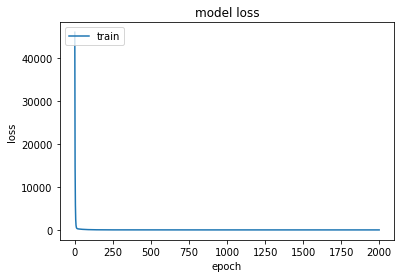

Done.
Test loss: 1.0310125648975372
Test accuracy: 0.8425000160932541


In [23]:
# Reference with normal neural net 
dropout_rate_dense = 0

X_train_tf_tens = tf.convert_to_tensor(X_train_tens, dtype=np.float32)
X_in_dense = Input(shape=(10, 8))
layer1 = TimeDistributed(Dense(50), input_shape=(10, 8))(X_in_dense)
dropout1_dense = TimeDistributed(Dropout(dropout_rate_dense))(layer1)
layer2 = TimeDistributed(Dense(50))(dropout1_dense)
dropout2_dense = TimeDistributed(Dropout(dropout_rate_dense))(layer2)
layer3 = TimeDistributed(Dense(8))(dropout2_dense)
model_dense = Model(inputs=X_in_dense, outputs=layer3)

#model_dense = Sequential()
#model_dense.add(TimeDistributed(Dense(50), input_shape=(10, 8)))
#model_dense.add(TimeDistributed(Dropout(dropout_rate_dense)))
#model_dense.add(TimeDistributed(Dense(50)))
#model_dense.add(TimeDistributed(Dropout(dropout_rate_dense)))
#model_dense.add(TimeDistributed(Dense(8)))

optimizer = Adagrad(lr=learning_rate)
model_dense.compile(optimizer=optimizer,
              loss='mean_squared_error',
              weighted_metrics=['accuracy'])
model_dense.summary()

validation_data = (X_train_tf_tens, X_train_tens)
history_dense = model_dense.fit(X_train_tens,
          X_train_tens,
          epochs=epochs,
          steps_per_epoch = 1,                      
          validation_data = validation_data,
          validation_steps = 1,
          shuffle=False,  # Shuffling data means shuffling the whole graph
         )
plt.plot(history_dense.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Evaluate model
eval_results = model_dense.evaluate(X_train_tens,
                              X_train_tens,
                              batch_size=50,
                              verbose=0)
print('Done.\n'
      'Test loss: {}\n'
'Test accuracy: {}'.format(*eval_results))

Visualization X_train:


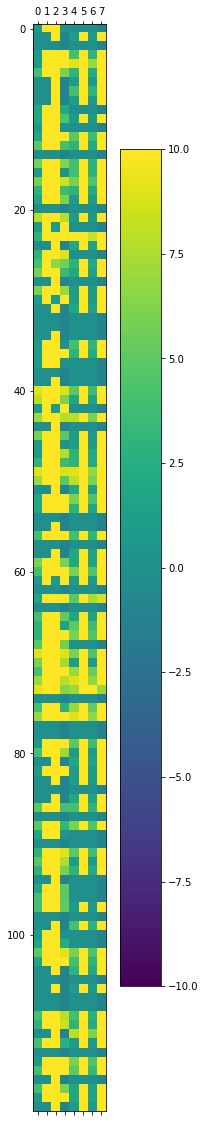

Visualization Prediction:


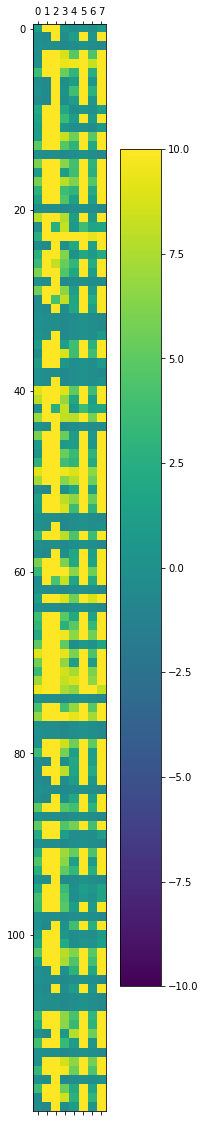

Visualization Error:


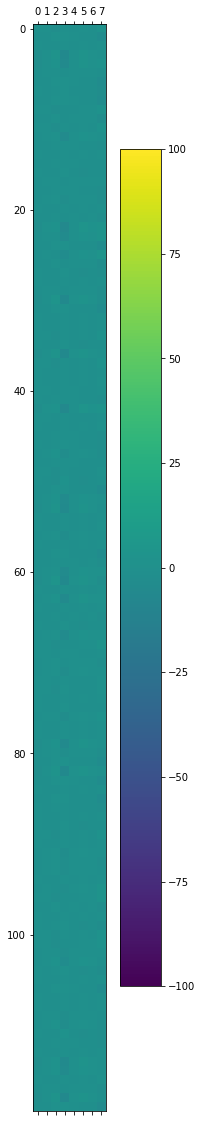

In [24]:
prediction_dense = model_dense.predict(X_train_tens, batch_size = 10)

print('Visualization X_train:')
fig = plt.figure(figsize=(5, 20))
ax = fig.add_subplot(111)
cax = ax.matshow(X_train_tens[:, 0, :], vmin=-10, vmax=10)
fig.colorbar(cax)
plt.show()

print('Visualization Prediction:')
fig = plt.figure(figsize=(5, 20))
ax = fig.add_subplot(111)
cax = ax.matshow(prediction_dense[:, 0, :], vmin=-10, vmax=10)
fig.colorbar(cax)
plt.show()

error = prediction_dense - X_train_tens

print('Visualization Error:')
fig = plt.figure(figsize=(5, 20))
ax = fig.add_subplot(111)
cax = ax.matshow(error[:, 0, :], vmin=-100, vmax=100)
fig.colorbar(cax)
plt.show()